# Language Identification Machine Model


# Introduction

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

## Problem Statement

Build a machine learning model that will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. 

# 1.1 Import Python Librariies

In [ ]:
# Loading Data
import pandas as pd
import numpy as np
import nltk
import string
import re
import time

# Data Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

# Model Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
#from scikitplot.metrics import plot_roc, plot_confusion_matrix

# Explore Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import style

import seaborn as sns

sns.set(font_scale=1.5)
style.use("seaborn-poster")

from wordcloud import WordCloud, STOPWORDS
from matplotlib.pyplot import rcParams

from sklearn.feature_extraction.text import CountVectorizer

# Import warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [ ]:
#download libraries
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
sns.set_style('whitegrid')

In [ ]:

nltk.download('averaged_perceptron_tagger')

# 1.2 Import Data

In [ ]:
train = pd.read_csv('data/train_set.csv')
test = pd.read_csv('data/test_set.csv') 

# 2. Exploratory Data Analysis (EDA)

In [ ]:
train_copy = train.copy()
test_copy = test.copy()

In [ ]:
train_copy.head()

In [ ]:
test_copy.head()

## 2.1 Data Overview

In [ ]:
train_copy.shape

In [ ]:
test_copy.shape

In [ ]:
test_copy.isnull().sum()

In [ ]:
train_copy.isnull().sum()

# 2.2 Class Distribution

In [ ]:
value_counts = train["lang_id"].value_counts()
value_counts.name = "Raw Number"

value_normd = train["lang_id"].value_counts(normalize=True)
value_normd.name = "Percentage"

display(pd.concat([value_counts, value_normd], axis=1))


In [ ]:
sns.countplot(train["lang_id"])
plt.show()

The data among classes is balance.

# 3. Data Preprocessing

**Techniques that we are going to use to clean our data**

- Removing Noise
- Stop Words
- Tokenisation
- Lemmatisation
- Speach tagging

## 3.1 Removing Noise

Noise will be removed with the following steps.

- Convert letters to lowercases
- Remove punctuation
- remove numbers

In [ ]:
def cleaner(text):
    """
    this function takes in a text and perform the following:
    -Convert letters to lowercases
    -remove -numbers
    -remove punctuation
    from the text field then return a clean text 
    """
    text = text.lower()
    to_del = [
        r"\d+",  # delete numeric values
        r"U+FFFD",  # remove the "character note present" diamond
    ]
    for key in to_del:
        text = re.sub(key, "", text)
    
    # strip punctuation and special characters
    text = re.sub(r"[,.;':@#?!\&/$]+\ *", " ", text)
    # strip excess white-space
    text = re.sub(r"\s\s+", " ", text)
    
    return text.lstrip(" ")

In [ ]:
train_copy['text'] = train_copy['text'].apply(cleaner)

In [ ]:
train_copy.tail(5)

### 3.2 Text Normalization

In [ ]:
def lemmatizer(df):
    df["length"] = df["text"].str.len()
    df["tokenized"] = df["text"].apply(word_tokenize)
    df["parts-of-speech"] = df["tokenized"].apply(nltk.tag.pos_tag)
    
    def str2wordnet(tag):
        conversion = {"J": wordnet.ADJ, "V": wordnet.VERB, "N": wordnet.NOUN, "R": wordnet.ADV}
        try:
            return conversion[tag[0].upper()]
        except KeyError:
            return wordnet.NOUN
    
    wnl = WordNetLemmatizer()
    df["parts-of-speech"] = df["parts-of-speech"].apply(
        lambda tokens: [(word, str2wordnet(tag)) for word, tag in tokens]
    )
    df["lemmatized"] = df["parts-of-speech"].apply(
        lambda tokens: [wnl.lemmatize(word, tag) for word, tag in tokens]
    )
    df["lemmatized"] = df["lemmatized"].apply(lambda tokens: " ".join(map(str, tokens)))
    
    return df

In [19]:
train_copy = lemmatizer(train_copy)
train_copy.head()

NameError: name 'wordnet' is not defined

# 4.1 Splitting out the X variable from the target

In [20]:
ftrain = train.copy()

In [21]:
y = ftrain['lang_id']
X = ftrain['text']

# 4.2 Data tranformation with TfidfVectorizer


In [39]:
vectorizer = TfidfVectorizer( max_df = 0.9, min_df = 2, ngram_range = (1, 2))
X_vectorized = vectorizer.fit_transform(X)


In [ ]:
TfidfVectorizer(min_df=2,
                                                max_df=0.9,
                                                ngram_range=(1, 2))

# 5. Modeling


## 5.1 Splitting the training data into a training and validation set

In [40]:
X_train,X_val,y_train,y_val = train_test_split(X_vectorized,y,test_size=.2,shuffle=True, stratify=y, random_state=42)

## 5.2 Model Fitting and Evaluation

### 5.2.1 Logistic Classifier

In [41]:
LogisticRegression(random_state=42,
                                  multi_class='ovr',
                                  n_jobs=1,
                                  C=1e5,
                                  max_iter=4000)

LogisticRegression(C=100000.0, max_iter=4000, multi_class='ovr', n_jobs=1,
                   random_state=42)

In [42]:

logreg = LogisticRegression(C=1e5, multi_class='ovr',
                                  n_jobs=1, random_state=42, max_iter=4000)
logreg.fit(X_train, y_train)
y_pred_lg = logreg.predict(X_val)
report = classification_report(y_val, y_pred_lg, output_dict=True)
results = pd.DataFrame(report).transpose()
results

,precision,recall,f1-score,support
afr,1.000000,1.000000,1.000000,600.000000
eng,0.995025,1.000000,0.997506,600.000000
nbl,0.994992,0.993333,0.994162,600.000000
nso,1.000000,0.996667,0.998331,600.000000
sot,0.996678,1.000000,0.998336,600.000000
ssw,1.000000,1.000000,1.000000,600.000000
tsn,0.998333,0.998333,0.998333,600.000000
tso,1.000000,1.000000,1.000000,600.000000
ven,1.000000,1.000000,1.000000,600.000000
xho,0.994992,0.993333,0.994162,600.000000


### 5.2.2 Random Forest Classifier

In [43]:
modelstart = time.time()
rf = RandomForestClassifier(max_features=4, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
report = classification_report(y_val, y_pred_rf, output_dict=True)
results = pd.DataFrame(report).transpose()
results

,precision,recall,f1-score,support
afr,1.000000,1.000000,1.000000,600.000000
eng,0.991736,1.000000,0.995851,600.000000
nbl,1.000000,0.976667,0.988196,600.000000
nso,0.998333,0.998333,0.998333,600.000000
sot,0.996678,1.000000,0.998336,600.000000
ssw,0.998336,1.000000,0.999167,600.000000
tsn,1.000000,0.996667,0.998331,600.000000
tso,1.000000,1.000000,1.000000,600.000000
ven,1.000000,1.000000,1.000000,600.000000
xho,0.994958,0.986667,0.990795,600.000000


### 5.2.3 Decision Tree Classifier

In [44]:
dt = DecisionTreeClassifier(random_state=42 )    
dt.fit(X_train, y_train)
y_pred_dc = dt.predict(X_val)
report = classification_report(y_val, y_pred_dc, output_dict=True)
results = pd.DataFrame(report).transpose()
results

,precision,recall,f1-score,support
afr,0.996667,0.996667,0.996667,600.000000
eng,0.990083,0.998333,0.994191,600.000000
nbl,0.918966,0.888333,0.903390,600.000000
nso,0.984694,0.965000,0.974747,600.000000
sot,0.980165,0.988333,0.984232,600.000000
ssw,0.915683,0.905000,0.910310,600.000000
tsn,0.965232,0.971667,0.968439,600.000000
tso,0.996644,0.990000,0.993311,600.000000
ven,0.989967,0.986667,0.988314,600.000000
xho,0.916239,0.893333,0.904641,600.000000


### 5.2.4 Support vector machine Classifier

In [45]:
modelstart = time.time()
svc = SVC(gamma = 0.8, C = 10, random_state=42)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_val)
report = classification_report(y_val, y_pred_svc, output_dict=True)
results = pd.DataFrame(report).transpose()
results

,precision,recall,f1-score,support
afr,1.000000,0.996667,0.998331,600.000000
eng,0.996672,0.998333,0.997502,600.000000
nbl,0.986777,0.995000,0.990871,600.000000
nso,1.000000,0.995000,0.997494,600.000000
sot,0.996678,1.000000,0.998336,600.000000
ssw,1.000000,1.000000,1.000000,600.000000
tsn,0.998333,0.998333,0.998333,600.000000
tso,1.000000,1.000000,1.000000,600.000000
ven,1.000000,1.000000,1.000000,600.000000
xho,0.993322,0.991667,0.992494,600.000000


### 5.2.5 Linear SVC

In [46]:
modelstart = time.time() 
linsvc = LinearSVC()
linsvc.fit(X_train, y_train)
y_pred_lsvc = linsvc.predict(X_val)
report = classification_report(y_val, y_pred_lsvc, output_dict=True)
results = pd.DataFrame(report).transpose()
results

,precision,recall,f1-score,support
afr,1.000000,1.000000,1.000000,600.000000
eng,0.995025,1.000000,0.997506,600.000000
nbl,0.994992,0.993333,0.994162,600.000000
nso,1.000000,0.996667,0.998331,600.000000
sot,0.996678,1.000000,0.998336,600.000000
ssw,1.000000,1.000000,1.000000,600.000000
tsn,0.998333,0.998333,0.998333,600.000000
tso,1.000000,1.000000,1.000000,600.000000
ven,1.000000,1.000000,1.000000,600.000000
xho,0.994992,0.993333,0.994162,600.000000


# 6. Model Analysis

# 6.1 F1 score evaluation

In [47]:
# Logistc regression F1 score

logreg_f1 = round(f1_score(y_val, y_pred_lg, average='weighted'),4)

# Random forest F1 score
rf_f1 = round(f1_score(y_val, y_pred_rf, average='weighted'),4)

# Decision tree F1 score
dt_f1 = round(f1_score(y_val, y_pred_dc, average='weighted'),4)

# Support Vector F1 score
svc_f1 = round(f1_score(y_val, y_pred_svc, average='weighted'),4)

# Linear Support Vector F1 score
linsvc_f1 = round(f1_score(y_val, y_pred_lsvc, average='weighted'),4)

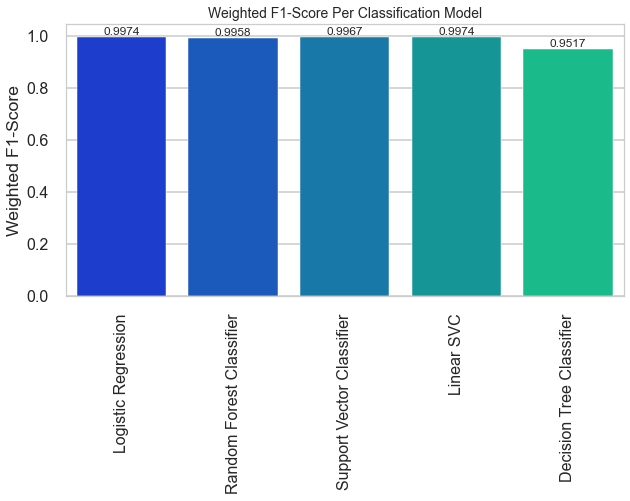

In [48]:
fig,axis = plt.subplots(figsize=(10, 5))
rmse_x = ['Logistic Regression','Random Forest Classifier','Support Vector Classifier','Linear SVC','Decision Tree Classifier']
rmse_y = [logreg_f1,rf_f1,svc_f1,linsvc_f1,dt_f1]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='winter')
plt.title('Weighted F1-Score Per Classification Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1-Score')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),4), fontsize=12, ha="center", va='bottom')
    
plt.show()

## 7.1 Test Data tranformation with Vectorizer

In [49]:
testx = test_copy['text']
test_vect = vectorizer.transform(testx)

In [50]:
# Random Forest
rfc_pred_t = rf.predict(test_vect)
# Multi-class Logistic Predict
lmc_pred_t = logreg.predict(test_vect)
#Decision Tree Predict
dtc_pred_t = dt.predict(test_vect)
# Support vector Machine Predict
#svc_pred_t = grid_SVC.predict(test_vect)
# Linear support vector Machine Predict
#linsvc_pred = grid_LSVC.predict(test_vect)
# AdaBoost Predict
#ad_pred = ad.predict(test_vect)

In [104]:
linsvc_pred = grid_LSVC.predict(test_vect)

# 8. Submitions

In [ ]:
test['lang_id'] = lmc_pred_t
test.head()

In [52]:
test[['index','lang_id']].to_csv('testsubmission.csv', index=False)

# 9. Conclusion

All models that were trained performanced well with an accuracy of over 93%. 